
[Scanpy Clustering Tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html]

Get Data:

```
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write 
```

32k genes, 2700 Samples. matrix.mtx sparse integer matrix.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.0 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.6.0 pandas==1.2.0 scikit-learn==0.24.1 statsmodels==0.12.2


Note I am missing some stuff found in the tutorial:

umap==0.4.2 python-igraph==0.7.1 leidenalg==0.7.0

In [3]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results


In [4]:
import anndata
import scipy.io
from pathlib import Path
DATA=Path("data/filtered_gene_bc_matrices/hg19")
a_data = anndata.AnnData(
    X=scipy.io.mmread(DATA/"matrix.mtx").T, 
    obs=pd.read_csv(DATA/"barcodes.tsv", sep = '\t', header=None), 
    var=pd.read_csv(DATA/"genes.tsv", sep = '\t', header=None, index_col=1, names=['gene_ids'])
)

/Users/jsteill/bin/Virt_Py_Envs/jlab2/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
# help(sc.read_10x_mtx)
a2_data = sc.read_10x_mtx(DATA, var_names='gene_symbols',cache=True)


... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [6]:
assert (a2_data.X - a_data.X).sum() == 0


In [13]:
print(len(list(a_data.var.index))-len(set(list(a_data.var.index))))
a_data.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
a2_data.var_names_make_unique()
print(len(list(a_data.var.index))-len(set(list(a_data.var.index))))

0
0


In [14]:
set(list(a_data.var.index))==set(list(a2_data.var.index))

True

normalizing counts per cell
    finished (0:00:00)


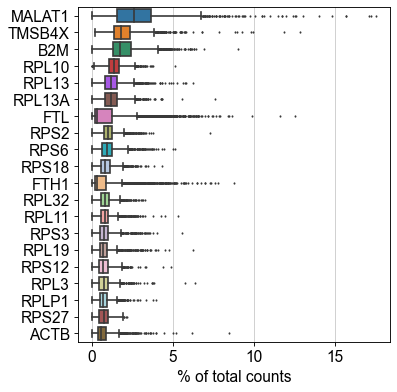

In [15]:
sc.pl.highest_expr_genes(a2_data, n_top=20, )